In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import resources

from keras.layers import Input, Dropout
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load RMS signals for autoencoder

In [2]:
exp = 'Test 8'
rms = resources.ae.RMS(exp)
rms.data.drop(['0', '1', '2'], axis=1, inplace=True)
rms._data = rms.data.T.reset_index(drop=True).T

--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------


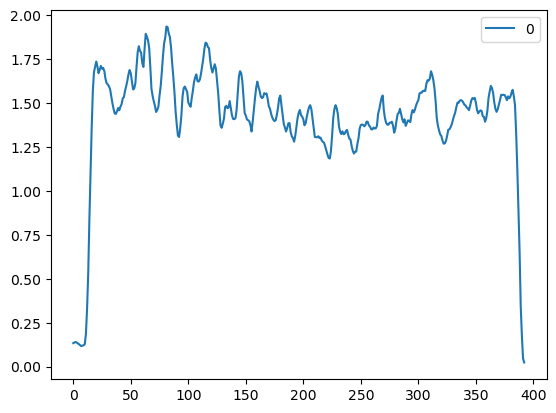

In [3]:
rms.data.plot(y=0);

Remove DC component from RMS signal and section to only between trigger points

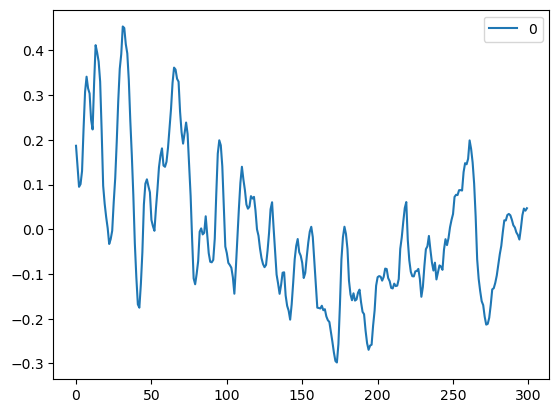

In [4]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

rms._data = rms.data.iloc[50:350, :].reset_index(drop=True)
rms._data = rms.data.apply(remove_dc, axis=0)
rms.data.plot(y=0);

In [5]:
full_rms = []
np.shape(rms.data)
for i in range(np.shape(rms.data)[1]):
    full_rms.extend(rms.data.iloc[:, i].values.T)
full_rms = np.array(full_rms).reshape(-1, 1)
print(f'Number of RMS samples: {np.shape(full_rms)}')

Number of RMS samples: (51900, 1)


In [6]:
np.isnan(full_rms).any()

False

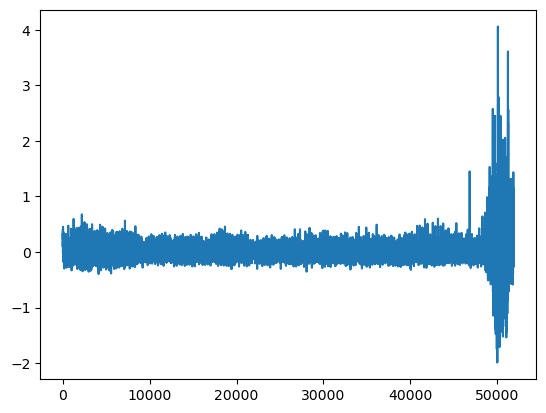

In [7]:
plt.plot(full_rms);

## Create sequences for autoencoder

In [8]:
SEQ_LEN = 150

def to_sequences(data, seq_len=SEQ_LEN):
    d = []
    for index in range(len(data) - seq_len + 1):
        d.append(data[index: (index + seq_len)])
    return np.stack(d)

x_train = to_sequences(full_rms, SEQ_LEN)
print(f'Training input shape: {x_train.shape}')

Training input shape: (51751, 150, 1)


## Split data and scale

In [9]:
NO_TRAIN_SIGS = 100
x_test = x_train[(NO_TRAIN_SIGS*300):]
x_train = x_train[:(NO_TRAIN_SIGS*300)]
print(f'Training input shape: {x_train.shape}')
print(f'Test input shape: {x_test.shape}')

Training input shape: (30000, 150, 1)
Test input shape: (21751, 150, 1)


In [10]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)
x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(-1, SEQ_LEN, 1)

## Create Autoencoder

In [11]:
autoe = Sequential()

autoe.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
autoe.add(LSTM(64, return_sequences=True))
autoe.add(Dropout(0.1))
autoe.add(LSTM(32, return_sequences=False))
autoe.add(Dropout(0.1))
autoe.add(RepeatVector(x_train.shape[1]))
autoe.add(LSTM(32, return_sequences=True))
autoe.add(Dropout(0.1))
autoe.add(LSTM(64, return_sequences=True))
autoe.add(Dropout(0.1))
autoe.add(TimeDistributed(Dense(x_train.shape[2])))

optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, clipnorm=1., clipvalue=0.5)
autoe.compile(optimizer=optimiser, loss='mean_squared_error')
autoe.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 150, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 150, 32)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 150, 32)           8320      
                                                        

In [12]:
history = autoe.fit(
    x_train, x_train,
    validation_split=0.2,
    # validation_data=(x_test, x_test),
    epochs=300,
    batch_size=64,
    use_multiprocessing=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min'),
    ]
)

Epoch 1/300
375/375 [==============================] - 112s 285ms/step - loss: 0.0156 - val_loss: 0.0093
Epoch 2/300
375/375 [==============================] - 106s 283ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 3/300
375/375 [==============================] - ETA: 0s - loss: 0.0098

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
x_train_pred = autoe.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50);
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples');

In [ ]:
i = 10
plt.plot(x_train[i])
plt.plot(x_train_pred[i])

In [ ]:
# Test data
x_test_pred = autoe.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50);
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
# Threshold
THRESHOLD = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {THRESHOLD}')

anomalies = test_mae_loss > THRESHOLD
print(f'Number of anomaly samples: {np.sum(anomalies)}')

In [ ]:
anomalous_data_indices = []
for data_idx in range(SEQ_LEN - 1, len(full_rms) - SEQ_LEN + 1):
    if np.all(anomalies[data_idx - SEQ_LEN + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_full_rms = pd.DataFrame(full_rms)
df_anom = df_full_rms.iloc[anomalous_data_indices]

fig, ax = plt.subplots(figsize=(14, 6))
df_full_rms.plot(legend=False, ax=ax)
df_anom.plot(legend=False, ax=ax, color='r');